In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdCoordGen
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

from rdkit.Chem import rdRGroupDecomposition

from IPython.display import HTML
from rdkit.Chem import QED
import rdkit_endpoints

import pandas as pd
import random
import itertools

from IPython.display import SVG
IPythonConsole.ipython_useSVG=True
IPythonConsole.drawOptions.minFontSize = 16
IPythonConsole.drawOptions.addStereoAnnotation = True
IPythonConsole.molSize = (900, 300)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/walker/builds/23-1/build/internal/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Part 1a: Input core SMILES

The FE/BE should provide a way for users to input a core smiles and display the image

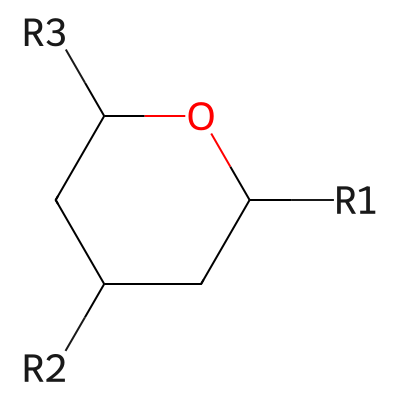

In [2]:
# Get SMILES for core
core_smi = "[*]C1CC([*])CC([*])O1 |$R1;;;;R2;;;R3;$|"

# Getting image data to display
svg_str = rdkit_endpoints.generate_image(core_smi)

# Display in jupyter notebook
SVG(svg_str)

## Part 1b: Input RGroup SMILES

Now the provided core should be used to figure out which rgroups to ask for. For example:

```
core_smi = "[*]C1CC([*])CC([*])O1 |$R1;;;;R2;;;R3;$|"
rdkit_endpoints.get_rgroup_labels(core_smi)
```

Will give `["R1", "R2", "R3]`, meaning that the FE should ask for a set of possible `R1` smiles, `R2` smiles, and `R3` smiles.

In [3]:
# After reading in RGroups, data format should look like this
rgroup_smiles = {
    "R1" : ["*N1CCCC1", "*O"],
    "R2" : ["*C", "*C1CCCNC1"],
    "R3" : ["CC(-*)=O", "*-C1CCNC1"]
}

## Just for jupyter notebook: get mols together to display in grid image

This is just so that we can look at all the rgroups and core together. I think in general the BE will use `generate_image` on the individual smiles and the FE will display each of them (if we want those displayed).

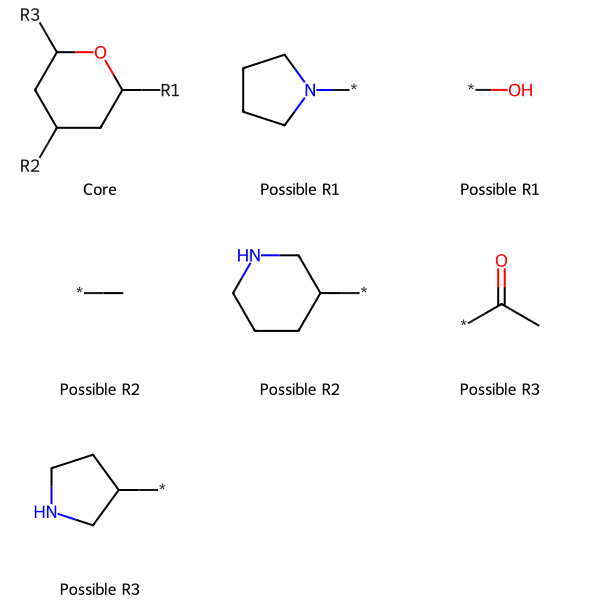

In [4]:
# Getting all mols into once list so that we can use MolsToGridImage to display,
# probably only needed for notebook
all_mols = [Chem.MolFromSmiles(core_smi)]
legends = ["Core"]
for k, v in rgroup_smiles.items():
    for m_smi in v:
        all_mols.append(Chem.MolFromSmiles(m_smi))
        legends.append(f"Possible {k}")
Draw.MolsToGridImage(all_mols,legends=legends,molsPerRow=3)

## Part 2: Perform rgroup enumeration

This should really just be calling `rgroup_enumerate`. The rest is formatting and image generation -- to create the images, BE should really just call `generate_image` on each of the smiles returned by `rgroup_enumerate`

Possible products:


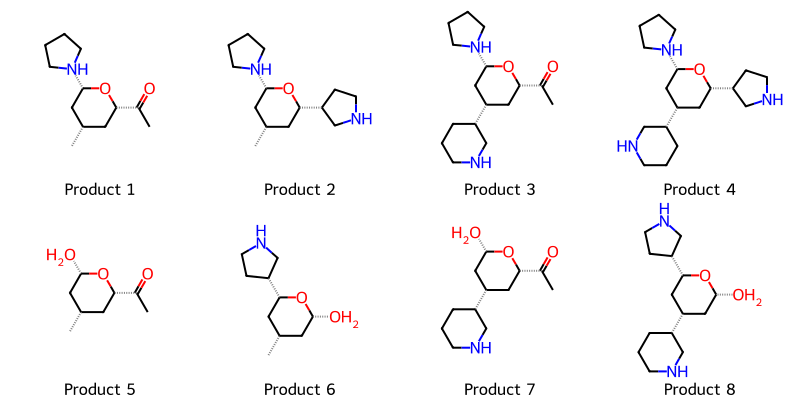

In [6]:
print("Possible products:")
product_smiles = rdkit_endpoints.rgroup_enumerate(core_smi, rgroup_smiles)

# This is extra -- just for alignment because it looks better. Can be ignored for now
products = [Chem.MolFromSmiles(smi) for smi in product_smiles]
scaff_copy = rdkit_endpoints._remove_rgroup_atoms(Chem.MolFromSmiles(core_smi))
rdDepictor.Compute2DCoords(scaff_copy)
for prod in products:
    rdDepictor.Compute2DCoords(prod)
    rdDepictor.GenerateDepictionMatching2DStructure(prod, scaff_copy)
titles = [f"Product {i}" for i in range(1, len(products) + 1)]

Draw.MolsToGridImage(products,legends = titles, molsPerRow=4)

## Step 3: Perform calculations on products & diplay data

From "Quantifying the chemical beauty of drugs", which RDKit QED calculations are based off of

```
Eight widely-used molecular properties were selected on the basis of published precedence for their relevance in determining druglikeness 3, 5, 22, 23:
    * MW: molecular weight
    * ALOGP: octanol-water partition coefficient
    * HBD: number of hydrogen bond donors 
    * HBA: number of hydrogen bond acceptors
    * PSA: molecular polar surface area
    * ROTB: number of rotatable bonds
    * AROM: the number of aromatic rings
    * ALERTS: number of structural alerts
```

We will probably add some properties for the students to calculate using the RDKit API that relate to the "goodness" value of the molecules.

Starting example: since we are working with small molecules, we want to limit # heavy atoms, so goodness value could include <5 heavy atoms. No more than x number of rotatable bonds, hydrophobicity. 


*Note*: The properties are all obtained via `get_QED_props` -- the rest of this is so we can visualize this in a notebook using pandas

In [10]:
column_names = ["Image"] + rdkit_endpoints.ALL_QED_PROPS + ["QED"]
qed_props = rdkit_endpoints.get_QED_props(product_smiles)

data = dict()
for smi, kv in zip(product_smiles, qed_props.items()):
    data[kv[0]] = [smi] + kv[1]

def sdf_formatter(mol_smi):
    mol = Chem.MolFromSmiles(mol_smi)
    drawer = rdMolDraw2D.MolDraw2DSVG(200,200)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

def display_table(df):
    format_dict={'Image' : sdf_formatter}
    raw = df.to_html(formatters=format_dict, escape=False,index=True)
    rval = HTML(raw)
    return display(rval)


df = pd.DataFrame.from_dict(data, orient='index', columns=column_names)
display_table(df)